# Drills and manual TF-IDF calculations from the unsupervised NLP section

### TF-IDF manual calculations

In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import gutenberg
nltk.download('gutenberg')
nltk.download('punkt')
import re
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
%matplotlib inline

my_list = ["The best Monty Python sketch is the one about the dead parrot, I laughed so hard.",
"I laugh when I think about Python's Ministry of Silly Walks sketch, it is funny, funny, funny, the best!",
"Chocolate is the best ice cream dessert topping, with a great taste.",
"The Lumberjack Song is the funniest Monty Python bit: I can't think of it without laughing.",
"I would rather put strawberries on my ice cream for dessert, they have the best taste.",
"The taste of caramel is a fantastic accompaniment to tasty mint ice cream."]

# tasty and funniest?
imp_words = ['monty', 'python', 'sketch', 'laugh', 'funny', 'best', 'ice cream', 'dessert', 'taste']
df = pd.DataFrame(index=imp_words)

# spacy test: We might use this library at some point.
nlp = spacy.load('en')
mp = nlp(my_list[0])
type(mp[0])

[nltk_data] Downloading package gutenberg to C:\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


spacy.tokens.token.Token

In [2]:
cvec = CountVectorizer(vocabulary=imp_words, stop_words='english')
X = cvec.fit_transform(my_list)

df = pd.DataFrame(X.toarray(), columns=cvec.get_feature_names()).T

for i, sent in enumerate(my_list):
    if 'ice cream' in sent:
        df.loc['ice cream', i] += 1
    if 'tasty' in sent:
        df.loc['taste', i] += 1
    if 'funniest' in sent:
        df.loc['funny', i] += 1
    if 'laughed' in sent:
        df.loc['laugh', i] += 1
    if 'laughing' in sent:
        df.loc['laugh', i] += 1
        
cf_list = []
for row in df.index:
    cf_list.append(sum(df.loc[row, :]))
    
df_list = []
for val in df.index:
    x = 0
    for entry in df.loc[val]:
        if entry > 0:
            x += 1
    df_list.append(x)
    
df['df'] = df_list
df['cf'] = cf_list

idf_list = []
for val in df['df']:
    idf_list.append(np.log2(len(my_list) / val))
    
tfidf_dict = {}
for col in df[[0, 1, 2, 3, 4, 5]]:
    x = (df[col] * idf_list)
    tfidf_dict[col] = x

display(df)
display(pd.DataFrame(tfidf_dict))

,0,1,2,3,4,5,df,cf
monty,1,0,0,1,0,0,2,2
python,1,1,0,1,0,0,3,3
sketch,1,1,0,0,0,0,2,2
laugh,1,1,0,1,0,0,3,3
funny,0,3,0,1,0,0,2,4
best,1,1,1,0,1,0,4,4
ice cream,0,0,1,0,1,1,3,3
dessert,0,0,1,0,1,0,2,2
taste,0,0,1,0,1,2,3,4


,0,1,2,3,4,5
monty,1.584963,0.000000,0.000000,1.584963,0.000000,0.0
python,1.000000,1.000000,0.000000,1.000000,0.000000,0.0
sketch,1.584963,1.584963,0.000000,0.000000,0.000000,0.0
laugh,1.000000,1.000000,0.000000,1.000000,0.000000,0.0
funny,0.000000,4.754888,0.000000,1.584963,0.000000,0.0
best,0.584963,0.584963,0.584963,0.000000,0.584963,0.0
ice cream,0.000000,0.000000,1.000000,0.000000,1.000000,1.0
dessert,0.000000,0.000000,1.584963,0.000000,1.584963,0.0
taste,0.000000,0.000000,1.000000,0.000000,1.000000,2.0


### Original Thinkful code

In [3]:
#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf = train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)

#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
# print('Original sentence:', X_train[5])
# print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948


In [5]:
#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:", total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
# paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
# for i in range(5):
#     print('Component {}:'.format(i))
#     print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 45.18624463028091


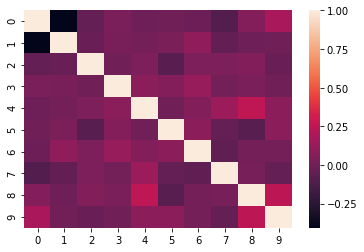

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [6]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix = pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

# Drills: Modified code

# Drill 0: Test set

In [7]:
# Remember, you will use the same model, only with the test set data.  Don't fit a new model by mistake!
X_test_lsa = lsa.transform(X_test_tfidf)

paras_by_component2=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component2.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
" Oh !    0.99929
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                                                                                          0.674572
Frank turned instantly to Emma , to claim her former promise ; and boasted himself an engaged man , which his father looked his most perfect approbation of  and it then appeared that Mrs . Weston was wanting _him_ to dance with Mrs . Elton himself , and that thei

# Drill 1: Tweaking tf-idf

Below is the same text example as earlier with the new TFIDF parameters:

A very few minutes more , however , completed the present trial .
{'present trial': 0.40861214459193756, 'completed present': 0.40861214459193756, 'minutes completed': 0.40861214459193756, 'trial': 0.40861214459193756, 'completed': 0.40861214459193756, 'minutes': 0.28967678179404555, 'present': 0.2850753208352705} 

The total variance ration explaned via SVD: 28.36640691309157

Component 0: That is _court_ .
Component 1: " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
Component 2: " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
Component 3: To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and j

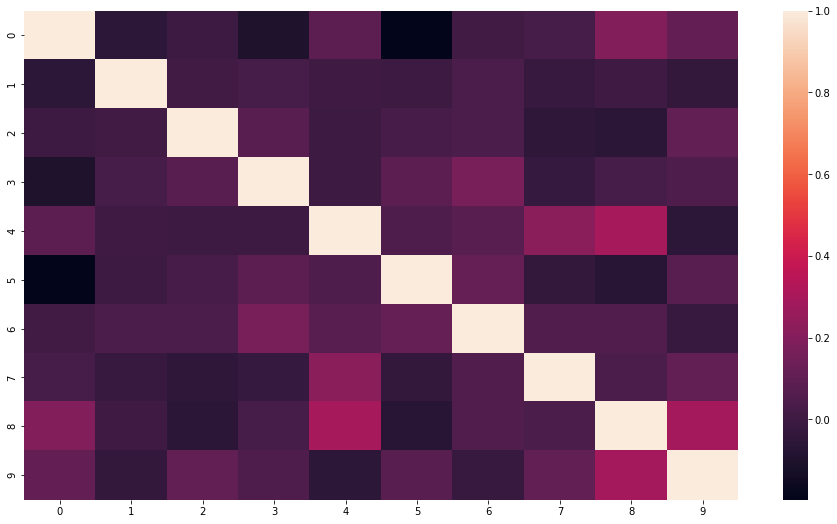

In [8]:
# Most of this code is recycled from the Thinkful curriculum example, above.

vectorizer2 = TfidfVectorizer(max_df=0.5,
                             stop_words='english', 
                             ngram_range=(1, 2))

emma_paras_tfidf2 = vectorizer2.fit_transform(emma_paras)
X_train2, X_test2 = train_test_split(emma_paras, test_size=0.4, random_state=0)
X_train_tfidf2, X_test_tfidf2 = train_test_split(emma_paras_tfidf2, 
                                                 test_size=0.4, random_state=0)
X_train2_copy = X_train_tfidf2.tocsr()
tfidf_bypara2 = [{} for _ in range(0, X_train2_copy.shape[0])]
terms2 = vectorizer2.get_feature_names()
for i, j in zip(*X_train2_copy.nonzero()):
    tfidf_bypara2[i][terms2[j]] = X_train2_copy[i, j]
    
print("Below is the same text example as earlier with the new TFIDF parameters:\n")    
print(X_train2[5])
print(tfidf_bypara2[5], '\n')

X_train_lsa2 = lsa.fit_transform(X_train_tfidf2)
print("The total variance ration explaned via SVD: {}\n"
      .format(svd.explained_variance_ratio_.sum()*100))

sim_matrix2 = pd.DataFrame(np.asarray(np.asmatrix(X_train_lsa2)
                                      * np.asmatrix(X_train_lsa2).T), index=X_train2)
fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(sim_matrix2.iloc[:10, :10], yticklabels=range(10), ax=ax)

for val in range(10):
    print("Component {}: {}".format(val, sim_matrix2.index[val]))